In [1]:
from torchvision.models import efficientnet_b0
import torch.nn as nn
from torch.nn import functional as F
import os
import torch
from tqdm import tqdm

class Ensemble(nn.Module):
    def __init__(self,model1,model2,model3):
        super(Ensemble,self).__init__()
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3

    def forward(self,x):
        a = self.model1(x)
        b = self.model2(x)
        c = self.model3(x)
        x = a+b+c
        x = nn.Softmax(dim=1)(x)
        return x

In [2]:
from model import ResNet, DenseNet

print(os.getcwd())
# resnet load
resnet50 = ResNet.load_model(num_classes=10)
checkpoint = torch.load('checkpoint/best_resnet50_963.pth')
resnet50.load_state_dict(checkpoint['model_state_dict'], strict=False)

# densenet load
densenet = DenseNet.load_model(growth_rate=32, block_config=(6, 12, 24, 16), num_init_features =64 ,num_classes = 10)
checkpoint = torch.load('checkpoint/best_densenet_968.pth')
densenet.load_state_dict(checkpoint['model_state_dict'], strict=False)

effi_net = efficientnet_b0()
in_eff = 1280
e_classifier=nn.Sequential(
    nn.Linear(in_eff,1000),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1000,10),

)
# 기본 모델은 fc 마지막이 1000개의 분류 , 맞춰주어야한다
effi_net.classifier = e_classifier

# efficientnetb0 load
checkpoint = torch.load('checkpoint/best_efficientb0_972.pth')
effi_net.load_state_dict(checkpoint['model_state_dict'], strict=False)


/home/seunmul/KNU_AICOSS_bitso


<All keys matched successfully>

In [3]:
def inference(model,test_loader, device):
    model.to(device)
    model.eval()
    history = {}
    correct = 0
    total = 0
    
    classes = (
        '63 Building', 'Namsan Tower', 'Gyeongbokgung Palace', 
        'Gwangjang Market', 'Hyundai Department Store', 'Ttukseom Hangang Park', 
        'Lotte World Tower', 'Bongeunsa Temple', 'Bukchon Hanok Village', 'Seoul Forest')
    class_correct = {classname : 0 for classname in classes}
    class_total = {classname : 0 for classname in classes}

    with torch.no_grad():
        for img, labels in tqdm(iter(test_loader)):
            img, labels = img.to(device), labels.to(device)

            outputs = model(img)

            # 가장 높은 것을 예측
            _, predicted = torch.max(outputs,1)
    
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for label, predict in zip(labels,predicted):
                if label == predict:
                    class_correct[classes[label]] +=1
                class_total[classes[label]] +=1
                
    val_acc = round(100* correct / total,1)
    for i in class_correct.keys():
        class_correct[i] = round(100*class_correct[i]/class_total[i],1)
    history['val_acc']=val_acc
    history['class_correct']=class_correct
    history['class_total']=class_total
    return history

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

def make_acc_bar(history):
    colors = sns.color_palette('hls',len(history['class_correct']))
    fig = plt.figure(figsize=(6,5))
    plt.bar(history['class_correct'].keys(),history['class_correct'].values(), color=colors)
    plt.xticks(range(len(history['class_correct'])), rotation=90)
    fig.suptitle(f"Total Acc : {history['val_acc']:.2f}%", fontsize=10)
    return fig

In [5]:
import os
from glob import glob
import pandas as pd

def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    label_df = pd.read_csv('./Dataset/train.csv')
    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, '*.PNG')))
    #print(glob(os.path.join(data_dir,'*.PNG')))
    # /로 짤린 것 중에서 맨 뒤( *.PNG) + 거기서 '.'으로 나뉘는 파일이름으로 정렬
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))

    # get label
    label_list.extend(label_df['label'])

    return img_path_list, label_list

def get_test_data(data_dir):
    img_path_list = []

    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, '*.PNG')))
    img_path_list.sort(key=lambda x : int(x.split('/')[-1].split('.')[0]) )

    return img_path_list


In [6]:
import torchvision.transforms.functional as TF
from typing import Sequence
from torchvision import transforms
import random

CFG = {
    'IMG_SIZE':256,
    'CROP_SIZE':224,
    'EPOCHS':200,
    'BATCH_SIZE':16,
}

img_mean = (0.475, 0.470, 0.458)
img_std = (0.295, 0.264, 0.254)

class MyRotateTransform:
    def __init__(self, angles: Sequence[int]):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(x, angle)


train_transform = transforms.Compose([
    transforms.ToPILImage(), # numpy --> PIL로 변경
    transforms.Resize([CFG['IMG_SIZE'],CFG['IMG_SIZE']]), #128 * 128이미지로 사이즈변경
    transforms.RandomAffine(20),
    transforms.CenterCrop(CFG['CROP_SIZE']),
    transforms.ToTensor(), # tensor로 변경
    transforms.Normalize(mean=img_mean, std=img_std), # 이미지 정규화 
    #MyRotateTransform([-90,0,90]),
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([CFG['IMG_SIZE'],CFG['IMG_SIZE']]),
    transforms.CenterCrop(CFG['CROP_SIZE']),
    transforms.ToTensor(),
    transforms.Normalize(mean=img_mean, std=img_std),
])

In [7]:
from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴
from torch.utils.data import Dataset

import cv2

class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None):
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self,index):
        img_path = self.img_path_list[index]
        image = cv2.imread(img_path)
        if self.transforms is not None:
            image = self.transforms(image)
        
        if self.train_mode:
            label = self.label_list[index]
            return image, label
        else:
            return image

    def __len__(self):
        return len(self.img_path_list)

In [8]:
GPU_NUM = 1 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
os.environ['CUDA_LAUNCH_BLOCKING']="1"
print(device)
print(f'torch version : {torch.__version__}')

cuda:1
torch version : 1.12.1


In [9]:
test_img_path,test_img_label = get_train_data('./Dataset/train')
print(test_img_path[:5], test_img_label[:5])
test_img_path = test_img_path[int((len(test_img_path)*0.7)):]
test_img_label = test_img_label[int((len(test_img_path)*0.7)):]
test_dataset = CustomDataset(test_img_path,test_img_label,train_mode=True,transforms=test_transform)
test_loader= DataLoader(test_dataset,batch_size =CFG['BATCH_SIZE'],shuffle=False)

['./Dataset/train/001.PNG', './Dataset/train/002.PNG', './Dataset/train/003.PNG', './Dataset/train/004.PNG', './Dataset/train/005.PNG'] [9, 4, 1, 1, 6]


In [10]:
ensemble = Ensemble(resnet50,densenet,effi_net)
ensemble.to(device)
print(ensemble)

Ensemble(
  (model1): Resnet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

100%|██████████| 14/14 [00:06<00:00,  2.11it/s]


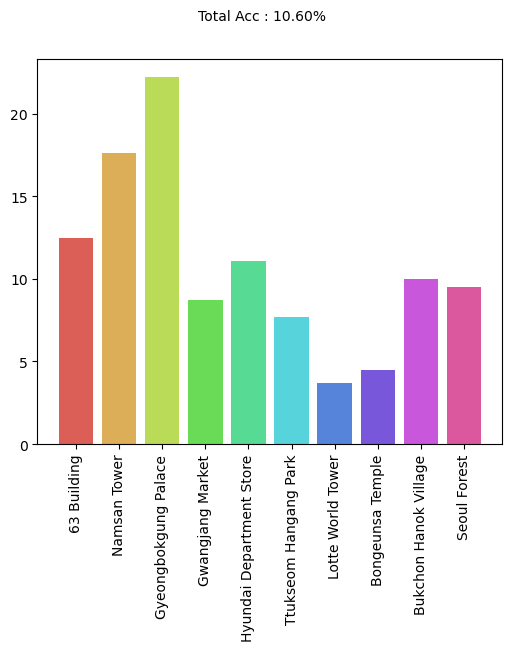

In [11]:
history = inference(ensemble,test_loader,device)
fig = make_acc_bar(history)